In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
import requests
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

from tqdm.notebook import tqdm
from collections import Counter

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from nltk.tokenize import word_tokenize
from torch import nn
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from transformers import BartForSequenceClassification, BartTokenizer, Trainer, TrainingArguments
from transformers import pipeline


2025-05-10 02:26:59.423484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746844019.611232      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746844019.663105      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Загружаем новости с сильными ветрами

In [3]:
wind = pd.read_excel('/kaggle/input/wind-bof/wind_bof_dis.xlsx')

In [4]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12734 entries, 0 to 12733
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              12734 non-null  int64         
 1   _ID                     12734 non-null  object        
 2   Event_ID                11005 non-null  object        
 3   News_link               12734 non-null  object        
 4   Text                    12734 non-null  object        
 5   News_length             12734 non-null  int64         
 6   Количество              12734 non-null  int64         
 7   News_source             12734 non-null  object        
 8   News_type               12734 non-null  object        
 9   Location_ATD4           12679 non-null  object        
 10  Location_other          11201 non-null  object        
 11  Location_geocoded       12734 non-null  object        
 12  Location_geocoded_bool  12734 non-null  bool  

Рассмотрим атрибут `Activities` - меры и мероприятия, предпренимавшиеся до, во време и после события, направленные на его предотвращение, минимизацию ущерба, ликвидацию последствий и т.п.
Попробуем обобщить их до более общих тематик, то есть разбить на группы

In [19]:
for i in wind['Activities'].sample():
    print(i)

Здесь мы рассказали, куда жители Котласского округа могут обратиться в случае некачественной уборки снега.


In [30]:
wind['Activities'].sample().values[0]

'Подразделения МЧС России, пожарные и спасатели готовы к ликвидации возможных последствий непогоды; рекомендовано принять профилактические меры и держать развитие ситуации под контролем.'

Применим [модель](https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-mnli-xnli) для задачи многоклассовой классификации по заданным группам

In [6]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")

sequence_to_classify = wind['Activities'].sample().values[0]
candidate_labels = ["мониторинг и прогнозирование", "информационное оповещение и информирование населения",
                    "организационные меры", "эвакуация и размещение населения", "инженерно-технические мероприятия",
                    "пожарная безопасность и тушение пожаров", "медицинская и санитарная защита",
                    "обеспечение жизнедеятельности и жизнеобеспечения", "правовые и административные меры",
                    "обучение и подготовка населения", "экологические и восстановительные мероприятия"]
output = classifier(sequence_to_classify, candidate_labels, multi_label=True)
print(output)
# Наилучший класс
best_class = output['labels'][0]
best_score = output['scores'][0]

# Фильтрация классов с вероятностью больше 0.8
filtered_classes = [(label, score) for label, score in zip(output['labels'], output['scores']) if score > 0.8]

if filtered_classes:
    print("Классы с вероятностью больше 0.8:")
    for label, score in filtered_classes:
        print(f"{label}: {score:.2f}")
else:
    best_class = output['labels'][0]
    best_score = output['scores'][0]
    filtered_classes = ((best_class), (best_score))
    print("Нет классов с вероятностью больше 0.8.")


config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Device set to use cuda:0


{'sequence': 'Томичам напоминают о необходимости соблюдения мер безопасности.', 'labels': ['информационное оповещение и информирование населения', 'медицинская и санитарная защита', 'пожарная безопасность и тушение пожаров', 'инженерно-технические мероприятия', 'правовые и административные меры', 'мониторинг и прогнозирование', 'эвакуация и размещение населения', 'обучение и подготовка населения', 'обеспечение жизнедеятельности и жизнеобеспечения', 'организационные меры', 'экологические и восстановительные мероприятия'], 'scores': [0.9416952133178711, 0.8347940444946289, 0.7607550024986267, 0.6896936297416687, 0.6862464547157288, 0.585482120513916, 0.5470598936080933, 0.4171846807003021, 0.3978750705718994, 0.276126503944397, 0.13979752361774445]}
Классы с вероятностью больше 0.8:
информационное оповещение и информирование населения: 0.94
медицинская и санитарная защита: 0.83


Разделим меры на отдельные предложения

In [10]:
news = []
wind['Activities'] = wind['Activities'].fillna('Нет мер')

In [11]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

def extract_measures_from_text(text):
    sentences = sent_tokenize(text, language='russian')
    for i in sentences:
        news.append(i)
# Пример
wind['Activities'].apply(extract_measures_from_text)
len(news)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


22131

In [12]:
news = list(set(news))

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer('sberbank-ai/sbert_large_nlu_ru')

# Пример: список мер, выделенных из текстов
measures_texts = [
    "Проведена эвакуация населения из опасной зоны",
    "Организована эвакуация жителей",
    "Укреплены дамбы для предотвращения наводнения",
    "Проведены работы по укреплению береговой линии",
    "Организована патрульная служба для контроля ситуации",
    # ...
]

embeddings = model.encode(measures_texts, convert_to_tensor=False)


In [13]:
from sentence_transformers import SentenceTransformer
import numpy as np
import torch
from sentence_transformers import SentenceTransformer


model = SentenceTransformer('sberbank-ai/sbert_large_nlu_ru').to(device)


embeddings = model.encode(news, convert_to_tensor=False)


Batches:   0%|          | 0/562 [00:00<?, ?it/s]

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

# Преобразование эмбеддингов в numpy массивы
embeddings = sentence_embeddings.numpy()

# Вычисление косинусного сходства
similarity = cosine_similarity(embeddings)

print("Косинусное сходство между предложениями:")
print(similarity)


Косинусное сходство между предложениями:
[[1.0000001  0.25634235]
 [0.25634235 1.0000001 ]]


In [41]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances

# Кластеризация по косинусному расстоянию
clustering = DBSCAN(eps=0.05, min_samples=25, metric='cosine').fit(embeddings)

# Получение меток кластеров
labels = clustering.labels_

# Создание DataFrame
df = pd.DataFrame({'text': news, 'cluster': labels})

# # Сохранение в CSV файл (по желанию)
# df.to_csv('clusters.csv', index=False)

# Вывод первых нескольких строк DataFrame для проверки
print(df.head())


                                                text  cluster
0  Рекомендации по безопасности: избегайте переох...       -1
1  МЧС Башкирии предупреждает жителей региона об ...       -1
2  Филиал «Россети Северо-Запад» работал в режиме...       -1
3  Открыт официальный счет для финансовой помощи ...       -1
4  Уходя из дома, закрывайте окна, балконные двер...       -1


In [42]:
df['cluster'].value_counts()

cluster
-1     16785
 0       502
 1       207
 2       116
 4        75
 3        62
 7        55
 6        34
 10       26
 11       26
 9        26
 8        26
 5        25
Name: count, dtype: int64

In [ ]:
import hdbscan

# Кластеризация с использованием HDBSCAN
hdbscan_clustering = hdbscan.HDBSCAN(min_cluster_size=5)
labels = hdbscan_clustering.fit_predict(embeddings)

# Создание DataFrame
df = pd.DataFrame({'text': news, 'cluster': labels})

# Вывод первых нескольких строк DataFrame для проверки
print(df.head())


In [ ]:
df['cluster'].value_counts()

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

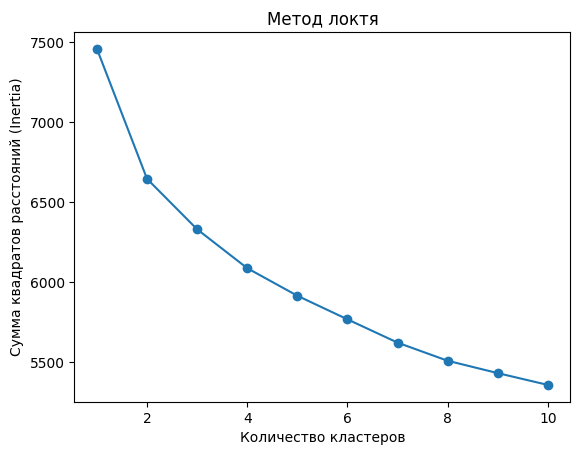

In [29]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Сумма квадратов расстояний (Inertia)')
plt.title('Метод локтя')
plt.show()


In [31]:
import torch
from sklearn.cluster import KMeans

# Преобразование данных в тензоры
embeddings_tensor = torch.tensor(embeddings).cuda()

# Кластеризация с использованием K-Means (на CPU)
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Создание DataFrame
df = pd.DataFrame({'text': news, 'cluster': labels})

# Вывод первых нескольких строк DataFrame для проверки
print(df.head())


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                                text  cluster
0  Просим ограничить выход из зданий, особенно де...        5
1  Аварийные бригады незамедлительно приступили к...        3
2  Во время эвакуации используются 3 вертолета Ми...        1
3           Будьте внимательны и осторожны за рулем!        5
4  Также проводится обработка общественных простр...        4


In [43]:
# df.to_excel('/kaggle/working/activities_Kmeans_10.xlsx')

In [32]:
df['cluster'].value_counts()

cluster
3    2631
9    2479
1    2245
4    2074
6    1696
7    1644
2    1537
0    1329
5    1296
8    1034
Name: count, dtype: int64

In [44]:
for i in df[df['cluster']==9]['text'].sample(10):
    print(i)
    print()

Областное управление МЧС России призывает жителей быть бдительными, соблюдать меры личной безопасности, как в быту, так и на улицах.

дана просьба быть внимательными и осторожными, максимальное исключение пребывания на улице, следить за парковкой автотранспорта

Рекомендуется воздержаться от туристических походов, выходов в лес, поездок на автотранспорте, находиться в защищенных помещениях, закрыть окна, убирать предметы с крыш и дворов.

Главное управление МЧС России по Саратовской области рекомендует ограничить выход из зданий, находиться в помещениях, укрыться в подземных переходах или подъездах зданий при сильном ветре, держаться подальше от рекламных щитов и крупных деревьев, а также закрыть окна домов и убрать предметы с балконов.

Горожан просят быть предельно внимательными, не прятаться от грозы и не парковать машины под кронами деревьев, рядом с рекламными конструкциями и строительными лесами.

Главное управление МЧС России по Республике Калмыкия рекомендует ограничить выход и

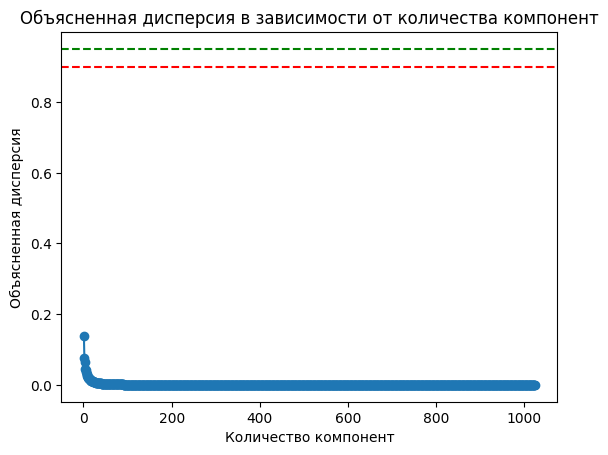

In [57]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Обучение PCA без уменьшения размерности
pca = PCA().fit(embeddings)

# Построение графика объясненной дисперсии
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Количество компонент')
plt.ylabel('Объясненная дисперсия')
plt.title('Объясненная дисперсия в зависимости от количества компонент')
plt.axhline(y=0.90, color='r', linestyle='--')  # Порог 90%
plt.axhline(y=0.95, color='g', linestyle='--')  # Порог 95%
plt.show()


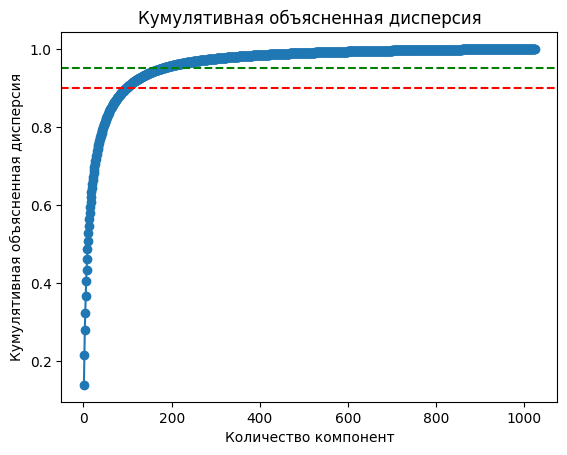

In [58]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.title('Кумулятивная объясненная дисперсия')
plt.axhline(y=0.90, color='r', linestyle='--')  # Порог 90%
plt.axhline(y=0.95, color='g', linestyle='--')  # Порог 95%
plt.show()


In [59]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Уменьшение размерности с помощью PCA
pca = PCA(n_components=20)
reduced_embeddings = pca.fit_transform(embeddings)

# Кластеризация с использованием K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(reduced_embeddings)

# Создание DataFrame
df = pd.DataFrame({'text': news, 'cluster': labels})

# Вывод первых нескольких строк DataFrame для проверки
print(df.head())


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                                text  cluster
0  Просим ограничить выход из зданий, особенно де...        5
1  Аварийные бригады незамедлительно приступили к...        1
2  Во время эвакуации используются 3 вертолета Ми...        3
3           Будьте внимательны и осторожны за рулем!        5
4  Также проводится обработка общественных простр...        8


In [60]:
df['cluster'].value_counts()

cluster
6    2618
1    2595
3    2103
8    1829
2    1713
0    1711
7    1535
4    1465
5    1286
9    1110
Name: count, dtype: int64

In [65]:
for i in df[df['cluster']== 3]['text'].sample(10):
    print(i)
    print()

Оперативный штаб осуществляет координацию всех действий.

заседание комиссии по ликвидации последствий урагана, отчеты структурных подразделений администрации, ликвидация всех поврежденных деревьев и подготовка к вывозу, работа коммунальных служб в полной готовности

{'инструктаж': 'провести инструктаж дежурных и диспетчерских служб', 'проверкаГотовности': 'проверить готовность техники и личного состава для работы в неблагоприятных условиях', 'оперативноеРеагирование': 'обеспечить оперативное реагирование сил и средств, участвующих в ликвидации аварий на сетях тепло - электро - и водоснабжения', 'готовностьРезервов': 'уточнить и привести в готовность силы и средства (в том числе резерв)', 'проверкаРезервныхИсточник': 'проверить исправность и готовность к работе резервных источников питания', 'мониторинг': 'организовать мониторинг паводковой обстановки на территории г. Улан-Удэ в ежесуточном режиме', 'информирование': 'Обо всех возникших предпосылках к ЧС немедленно информировать старше

In [55]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Уменьшение размерности с помощью PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Кластеризация с использованием K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(reduced_embeddings)

# Создание DataFrame
df = pd.DataFrame({'text': news, 'cluster': labels})

# Вывод первых нескольких строк DataFrame для проверки
print(df.head())


                                                text  cluster
0  Просим ограничить выход из зданий, особенно де...        2
1  Аварийные бригады незамедлительно приступили к...        1
2  Во время эвакуации используются 3 вертолета Ми...        0
3           Будьте внимательны и осторожны за рулем!        2
4  Также проводится обработка общественных простр...        4


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances

# Кластеризация по косинусному расстоянию
clustering = DBSCAN(eps=0.2, min_samples=2, metric='cosine').fit(embeddings)

labels = clustering.labels_
# for label in set(labels):
#     print(f"\nКластер {label}:")
#     for text, cluster_label in zip(news, labels):
#         if cluster_label == label:
#             print(f" - {text}")
set(labels)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21}

In [12]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, T5EncoderModel


def pool(hidden_state, mask, pooling_method="cls"):
    if pooling_method == "mean":
        s = torch.sum(hidden_state * mask.unsqueeze(-1).float(), dim=1)
        d = mask.sum(axis=1, keepdim=True).float()
        return s / d
    elif pooling_method == "cls":
        return hidden_state[:, 0]

inputs = [
    # 
    "categorize_topic: ⚠️ Внимание! Экстренное предупреждение!   ☔  По данным метеорологических служб, сегодня ожидается шторм с порывами ветра до 25 м/с.  ❗Уровень погодной опасности — 9 баллов.  ⏰ Погода ухудшится примерно в 15:00.  🏡 Просим вас быть осторожными и по возможности не выходить из дома в ближайшее время.  ⚠️ Ожидаются серьёзные разрушения: ветер может легко ломать деревья, срывать кровли и рекламные борды.",
    "categorize_entailment: Сегодня ожидается очень сильный ветер. Сидите дома, не стойте рядом с деревьями и на балконах",
    "search_query: Сегодня ожидается очень сильный ветер. Сидите дома, не стойте рядом с деревьями и на балконах",
    # 
    "categorize_topic: опасное природное явление",
    "categorize_entailment: сидите дома. не стойте под деревьями",
    "search_document: Сидите дома. Не стойте под деревьями"
]

tokenizer = AutoTokenizer.from_pretrained("ai-forever/FRIDA")
model = T5EncoderModel.from_pretrained("ai-forever/FRIDA")

tokenized_inputs = tokenizer(inputs, max_length=512, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    outputs = model(**tokenized_inputs)
    
embeddings = pool(
    outputs.last_hidden_state, 
    tokenized_inputs["attention_mask"],
    pooling_method="cls" # or try "mean"
)

embeddings = F.normalize(embeddings, p=2, dim=1)
sim_scores = embeddings[:3] @ embeddings[3:].T
print(sim_scores.diag().tolist())
# [0.9360030293464661, 0.8591322302818298, 0.728583037853241]


[0.9393018484115601, 0.8039394021034241, 0.5367608070373535]


In [16]:
import pandas as pd
import torch
import torch.nn.functional as F
import time
from transformers import AutoTokenizer, T5EncoderModel
start_time = time.time()

df = wind.copy().sample(20)
# Объединение столбцов в один входной текст
df['input_text'] = df.apply(lambda row: f"categorize_topic: {row['Text']}," +
f"categorize_topic: {row['Activities']}", axis=1)

# Инициализация токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained("ai-forever/FRIDA")
model = T5EncoderModel.from_pretrained("ai-forever/FRIDA")

# Токенизация объединенного текста
tokenized_inputs = tokenizer(df['input_text'].tolist(),
                             max_length=512, padding=True,
                             truncation=True, return_tensors="pt")

# Вычисление эмбеддингов
with torch.no_grad():
    outputs = model(**tokenized_inputs)

embeddings = pool(
    outputs.last_hidden_state, 
    tokenized_inputs["attention_mask"],
    pooling_method="cls"  # или попробуйте "mean"
)

embeddings = F.normalize(embeddings, p=2, dim=1)
end_time = time.time()
execution_time = end_time - start_time
print(f"\nВремя выполнения: {execution_time//60:.2f} минут")


Время выполнения: 1.00 минут


In [16]:
from sentence_transformers import SentenceTransformer

# loads model with CLS pooling
# model = SentenceTransformer("ai-forever/FRIDA")

paraphrase = model.encode(["В Ярославской области разрешили работу бань, но без посетителей", "Ярославским баням разрешили работать без посетителей"], prompt_name="paraphrase")
print(paraphrase[0] @ paraphrase[1].T) # 0.9360032

categorize_entailment = model.encode(["Погибло 10 человек, 20 увезли на скорой",
                                      "медицина"], prompt_name="categorize_topic")
print(categorize_entailment[0] @ categorize_entailment[1].T) # 0.8591322

query_embedding = model.encode("Сколько программистов нужно, чтобы вкрутить лампочку?", prompt_name="search_query")
document_embedding = model.encode("Чтобы вкрутить лампочку, требуется три программиста: один напишет программу извлечения лампочки, другой — вкручивания лампочки, а третий проведет тестирование.", prompt_name="search_document")
print(query_embedding @ document_embedding.T) # 0.7285831

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.9360032


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.8129798


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.7285831


In [7]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import time

# Начало отсчета времени
start_time = time.time()

# Загрузка модели с CLS pooling
# model = SentenceTransformer("ai-forever/FRIDA")

# Пример DataFrame (замените на ваш DataFrame)
df = wind.copy()

# Функция для верификации
def to_verify(row):
    text = row['Text']
    phenomena = row['Phenomena']
    
    # Получение эмбеддингов
    text_embedding = model.encode(text,
                                  prompt_name='categorize_topic',
                                  show_progress_bar=False)
    phenomena_embedding = model.encode(phenomena,
                                       prompt_name='categorize_topic',
                                       show_progress_bar=False)
    
    # Вычисление косинусного сходства
    similarity_score = text_embedding @ phenomena_embedding.T
    return similarity_score

# Применение функции к каждой строке DataFrame
df['score_Phenomena'] = df.apply(to_verify, axis=1)

# Завершение отсчета времени
end_time = time.time()
execution_time = end_time - start_time
print(f"\nВремя выполнения: {execution_time // 60:.2f} минут")


Время выполнения: 21.00 минут


In [8]:
df['score_Phenomena'].describe()

count    12734.000000
mean         0.884728
std          0.049493
min          0.708113
25%          0.854804
50%          0.896963
75%          0.923907
max          0.971253
Name: score_Phenomena, dtype: float64

In [5]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import time

# Начало отсчета времени
start_time = time.time()

# Загрузка модели с CLS pooling
model = SentenceTransformer("ai-forever/FRIDA")

# Пример DataFrame (замените на ваш DataFrame)
df = wind.copy()

# Функция для верификации
def to_verify(row):
    text = row['Text']
    phenomena = row['Phenomena']
    
    # Получение эмбеддингов
    text_embedding = model.encode(text,
                                  prompt_name='categorize_topic',
                                  show_progress_bar=False)
    phenomena_embedding = model.encode('сильный ветер',
                                       prompt_name='categorize_topic',
                                       show_progress_bar=False)
    
    # Вычисление косинусного сходства
    similarity_score = text_embedding @ phenomena_embedding.T
    return similarity_score

# Применение функции к каждой строке DataFrame
df['score_wind'] = df.apply(to_verify, axis=1)

# Завершение отсчета времени
end_time = time.time()
execution_time = end_time - start_time
print(f"\nВремя выполнения: {execution_time // 60:.2f} минут")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/509 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/823 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.29G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.70M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/5.59M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]


Время выполнения: 22.00 минут


In [6]:
df['score_wind'].describe()

count    12734.000000
mean         0.882092
std          0.038387
min          0.701751
25%          0.852497
50%          0.895564
75%          0.911722
max          0.951818
Name: score_wind, dtype: float64

In [18]:
# Вычисление скоров для каждой пары
scores = embeddings @ embeddings.T

# Печать скоров
df['scores'] = scores.diag().tolist()
print(df['scores'])

9560     1.0
12028    1.0
10204    1.0
8111     1.0
800      1.0
11265    1.0
4542     1.0
3831     1.0
10788    1.0
9499     1.0
3474     1.0
1268     1.0
5159     1.0
10622    1.0
5895     1.0
9034     1.0
8428     1.0
1573     1.0
6577     1.0
10050    1.0
Name: scores, dtype: float64


In [5]:
len(wind)

12734

In [13]:
import time
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.perf_counter()

# Загрузка модели и токенизатора
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli').to(device)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

# Пример DataFrame (замените на ваш DataFrame)
res = wind[['Text']]

def to_verify_bart(text):
    label = 'сильный ветер'
    premise = text
    hypothesis = f'This example is {label}.'
    
    # Токенизация и перемещение на устройство
    x = tokenizer.encode(premise, hypothesis, return_tensors='pt', truncation=True).to(device)
    
    # Получение логитов
    logits = nli_model(x)[0]
    
    # Вычисление вероятности
    entail_contradiction_logits = logits[:, [0, 2]]
    probs = entail_contradiction_logits.softmax(dim=1)
    prob_label_is_true = probs[:, 1]
    return prob_label_is_true.item()  # Возвращаем скалярное значение

# Применение функции к каждой строке DataFrame
res['wind_score'] = res['Text'].apply(to_verify_bart)

end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Время выполнения: {round(execution_time / 60, 2)} мин")


Время выполнения: 27.11 мин


/tmp/ipykernel_31/1242020041.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['wind_score'] = res['Text'].apply(to_classify)


In [14]:
res['wind_score'].describe()

count    12734.000000
mean         0.887946
std          0.146392
min          0.014956
25%          0.867059
50%          0.934340
75%          0.973129
max          0.999676
Name: wind_score, dtype: float64

In [15]:
import time
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_time = time.perf_counter()

# Загрузка модели и токенизатора
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli').to(device)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

# Пример DataFrame (замените на ваш DataFrame)
res_ph = wind[['Text', 'Phenomena']]

def to_verify_bart(row):
    label = row['Phenomena']
    premise = row['Text']
    hypothesis = f'This example is {label}.'
    
    # Токенизация и перемещение на устройство
    x = tokenizer.encode(premise, hypothesis, return_tensors='pt', truncation=True).to(device)
    
    # Получение логитов
    logits = nli_model(x)[0]
    
    # Вычисление вероятности
    entail_contradiction_logits = logits[:, [0, 2]]
    probs = entail_contradiction_logits.softmax(dim=1)
    prob_label_is_true = probs[:, 1]
    return prob_label_is_true.item()  # Возвращаем скалярное значение

# Применение функции к каждой строке DataFrame
res_ph['wind_score'] = res_ph.apply(to_verify_bart, axis=1)

end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Время выполнения: {round(execution_time / 60, 2)} мин")


Время выполнения: 27.26 мин


/tmp/ipykernel_31/4216801656.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_ph['wind_score'] = res_ph.apply(to_verify_bart, axis=1)


In [16]:
res_ph['wind_score'].describe()

count    12734.000000
mean         0.775066
std          0.259712
min          0.001351
25%          0.707024
50%          0.888475
75%          0.952751
max          0.999602
Name: wind_score, dtype: float64